## Approach

* This is a simplied version of YOLO. The input image is 512x512. YOLO was intended to train on images which all contained at least one object, most multiple objects. The architecture and loss functions have been adapted for this case, where not every image contains an object and there are at most 4 ROIs per image. 
* Since the maximum number of ROIs in each image is 4 we decided to use a 2x2 grid to simplify the network. In the case where multiple ROIs occur in the same cell we combine the ROIs into a single ROI by expanding the box to include both. Each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
    * We have removed the entire classification section, using the confidence to indicate whether there is an ROI in the cell instead.
* A sigmoid is applied to the output of the network to result in values between 0 and 1    
* The x and y coordinates are offsets from the upper left corner of each cell, the w and h are percentage of the total width.
* The loss function is based on YOLO with some differences:
    * The weights of the components have been updated
    * The classification loss has been removed.
    * The "objectness" loss of YOLO tries to make the confidence match the actual IOU. Since our model only outputs one box per cell, this doesn't really make any sense and ends up driving the confidence down to the IOU. We replace this by an IOU loss which subtracts the IOU for that cell from 1.

## Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* There are two dilated convolutions at the end of the network to provide context.
* The dilated convolutions are followed by two strided convolutions which downsize to 2x2.
* Finally there are a series of 1x1 convolutions which output a 2x2x5 tensor.
* We are using an Adam optimizer with gradient clipping to avoid exploding gradients, which had been a problem.

## Predictions
* To generate our predictions we loop through each cell of the output
* We unnormalize the output to get the actual values
* If the confidence is greater than 0.5 and the box has width and height we append it to the list of candidates.
* We apply non-max suppression to remove duplicates.
* The remaining boxes are concatenated onto the output string.

**Change Log:**
* v3 - changing output to 8x8 grid from 16x16; changed model to downsample one more time; adjusted network accordingly. 
* v4 - changed output to 4x4 grid, no image has more than 3 ROIs so this may work better? 
    * Using center point of ROI to predict instead of upper left corner.
* v5 - We only calculate MSE loss for boxes with a confidence over 0.5 or actual truth since we don't care about predictions for boxes that are not ROIs. This will prevent the network from being constrained by outputting 0s for boxes that don't exist.
* v6 - centering input data so maybe bboxes can be output more accurately? Also centering the image
* v6.2 - labels have ROI centered in center of cell by default instead of mean location.
* v8 - using custom loss function based on YOLO loss. Set default height and width to 1 px because 0 sent the gradients to -inf which screwed everything up.
* v10 - using 2x2 grid as output
* v12 - changing layout of model slightly - replaced final pools with convs with strides; reduced number of params; ensure that there is at least one positive image per batch.
* v13 - tweaking architecture slightly.
* v14 - going to 5x5 grid
* v15 - downsizing with average and max pool followed by 1x1 convolutions
* v15.2 - fixed an error where a layer of the network was being bypassed, removed some layers to prevent overfitting, training on labels with jittered ROIs
* v18 - separating fc branches for confidence and boxes, might work better?
* v19 - removing double pools and just using a simple max pool
* v20 - adding more layers to network, simplifying metrics and loss function
* v21 - trying 7x7 grid, removing one downsampling layer to keep input size reasonable
* v22 - some minor changes to network
* v23 - adding spatial dropout to prevent overfitting, other minor changes
* v24 - separating augmentation into discrete levels so we can slowly add it to speed up training, minor changes to network
* v25 - removed IOU component of loss function which was royally screwing everything up, removed some layers of network to prevent overtfitting
* v26 - adding some layers back, training from scratch with better weighted loss function


In [0]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip install -q pydicom 
!pip install -q imgaug 
!pip install -q kaggle
!pip install -q tqdm 

In [0]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
from skimage.filters import gaussian
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
        'mimeType': 'application/octet-stream',
     }

    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [0]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    w = boxes[:,2]
    h = boxes[:,3]
 
    x2 = x1 + w
    y2 = y1 + h

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (w + 1) * (h + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick]#.astype("int")

# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

# sigmoid in numpy, with limit to avoid nans                             
def sigmoid(x):
    # to avoid NaNs set a lower floor on x values
    y = np.maximum(x, -700)
    y = np.minimum(y, 700)
    return 1 / (1 + np.exp(-y))    

# adjust contrast of image
def change_contrast(img, contrast_factor):
    mean = np.mean(img)
    img = (img - mean) * contrast_factor + mean
    return img

def get_intersect(box1, box2):
    # unpack each box
    x1, y1, w1, h1, c1 = box1
    x2, y2, w2, h2, x2 = box2
    
    # get the far corners
    x1_f = x1 + w1
    y1_f = y1 + h1
    x2_f = x2 + w2
    y2_f = y2 + h2
    
    # get corners of intersection
    x1_i = np.maximum(x1, x2)
    y1_i = np.maximum(y1, y2)
    x2_i = np.minimum(x1_f, x2_f)
    y2_i = np.minimum(y1_f, y2_f)
    
    w_i = x2_i - x1_i
    h_i = y2_i - y1_i
    
    w_i = np.maximum(w_i, 0)
    h_i = np.maximum(h_i, 0)

    intersect_area = w_i * h_i
    
    return intersect_area  
  
# helper function to calculate IoU
def calculate_iou(box1, box2):
    x11, y11, w1, h1 = box1[:4]
    x21, y21, w2, h2 = box2[:4]
    assert w1 * h1 > 0
    assert w2 * h2 > 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union  

# calculate IOU where there can be multiple overlapping truths and predictions
def calc_iou_better(y_true, y_pred):
    label_array = np.zeros((1024, 1024))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for truth in y_true:
        x,y,w,h = truth[:4].astype(int)  
        label_array[y:y+h, x:x+w] = 1
                
    pred_array = np.zeros((1024, 1024))
    for pred in y_pred:
        x,y,w,h = pred[:4].astype(int)

        # update the pixels
        pred_array[y:y+h, x:x+w] = 1
                
    true_area = np.sum(label_array)
    pred_area = np.sum(pred_array)
    
    intersect_area = np.sum((pred_array == 1) & (label_array == 1))
    
    union = true_area + pred_area - intersect_area
    
    iou = intersect_area / (union + 1e-6)
    
    return iou      
      
def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    
    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """
    
    # According to the introduction, images with no ground truth bboxes will not be 
    # included in the map score unless there is a false positive detection (?)
        
    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return None
    elif (len(boxes_true) == 0) and (len(boxes_pred) != 0):
        return 0
    
    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
    
    map_total = 0
    
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = calculate_iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
                
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    
    return map_total / len(thresholds)      

# given the label or predictions, return a list containing the actual coordinates
# for each box
def unnorm_label(label, threshold=0.5):
    grid_size = label.shape[0]
    cell_size = 1024 / grid_size
    
    boxes = []
    # loop through the cells of our label
    for i in range(grid_size):
        for j in range(grid_size):
            # if we have a box in a cell
            if label[i,j,0] > threshold:
                # unpack the data
                c, x, y, w, h = label[i, j]
                
                # unnormalize the data
                w, h = int(w*1024), int(h*1024)
                x = unnorm(x, j, cell_size)
                y = unnorm(y, i, cell_size)
                
                # get the corners
                x = int(x - (w / 2))
                y = int(y - (h / 2))
                
                # it's possible the corner is in another cell, if so catch the error
                x = np.maximum(x, 0)
                y = np.maximum(y, 0)
                    
#                 print(x, y, w, h, "box:", i, j)
                boxes.append([x, y, w, h, c])
    
    return boxes

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [6]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
if not os.path.exists("./stage_1_detailed_class_info.csv.zip"):
    !kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 72.0MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 66.0MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 121MB/s]
 96% 363M/377M [00:02<00:00, 104MB/s] 
100% 377M/377M [00:03<00:00, 130MB/s]
100% 3.28G/3.29G [00:23<00:00, 176MB/s]
100% 3.29G/3.29G [00:23<00:00, 150MB/s]
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 69.9kB/s]


In [7]:
# unzipping takes a few minutes
if not os.path.exists("./stage_2_train_labels.csv"):
    print("Unzipping...")
    !unzip -q -o stage_2_test_images.zip -d stage_1_test_images
    !unzip -q -o stage_2_train_images.zip -d stage_1_train_images
    !unzip -q -o stage_2_train_labels.csv.zip

Unzipping...


# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [8]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [9]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
if not os.path.exists("./yolo_labels_centered_7x7_11b_2.p"):
    !gsutil cp gs://{bucket_name}/yolo_labels_centered_7x7_11b_2.p ./yolo_labels_centered_7x7_11b_2.p

Updated property [core/project].
Copying gs://pneumonia/yolo_labels_centered_7x7_11b_2.p...
- [1 files][ 51.8 MiB/ 51.8 MiB]                                                
Operation completed over 1 objects/51.8 MiB.                                     


In [0]:
with open('yolo_labels_centered_7x7_11b_2.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

# Load filenames

In [12]:
random.seed(724)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.12)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23482
n valid samples 3202


In [0]:
positive_images = []

for filename in pneumonia_locations:
    label = pneumonia_locations[filename][...,0]
    if np.max(label) > 1e-6:
        if filename + ".dcm" in train_filenames:
            positive_images.append(filename + ".dcm")

 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [0]:
BATCH_SIZE = 20
IMAGE_SIZE = 336
GRID_SIZE = 7
CELL_SIZE = 1024 / GRID_SIZE
CHECKPOINT_PATH = "yolo26_1_336.h5"

In [0]:
if not os.path.exists(CHECKPOINT_PATH):
  !gsutil cp gs://{bucket_name}/{CHECKPOINT_PATH} ./{CHECKPOINT_PATH}

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=0, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
    
    def augment_imgs(self, img, confs, boxes):
        ## always do these augmentations
        # flip the image half the time
        if random.random() > 0.5:
            img = np.fliplr(img)
            
            # update our x coords
            mask = (confs != 0)
            
            # flip
            boxes[mask, 0] = (1 - boxes[mask,0])
            
            # flip our boxes lr on axis 0
            boxes = np.flip(boxes, axis=1)   
            
            # flip the confidences lr as well
            confs = np.flip(confs, axis=1)            
        
        # small shifts
        if random.random() > 0.5:  
            ## small random shifts
            h_offset = np.random.randint(low=0, high=8)
            v_offset = np.random.randint(low=0, high=8)

            # crop the images
            img = img[v_offset:,h_offset:]
        
        # level one augmentation
        if self.augment >= 1:
            # random crop or pad
            crop_or_pad = random.random()
            
            # crop
            if crop_or_pad > 0.66:
                # crop by max of 16 pixels
                h_offset_1 = np.random.randint(low=0, high=30)
                v_offset_1 = np.random.randint(low=0, high=30)

                h_offset_2 = 1024 - np.random.randint(low=0, high=30)
                v_offset_2 = 1024 - np.random.randint(low=0, high=30)

                # crop the images
                img = img[v_offset_1:v_offset_2,h_offset_1:h_offset_2]

                # update the labels - make sure they are positive
                boxes[...,0] = np.maximum((boxes[...,0] - (h_offset_1 / CELL_SIZE)), 0.001)
                boxes[...,1] = np.maximum((boxes[...,1] - (v_offset_1 / CELL_SIZE)), 0.001)

            # pad
            elif crop_or_pad > 0.33:
                h_offset_1 = np.random.randint(low=0, high=30)
                v_offset_1 = np.random.randint(low=0, high=30)

                h_offset_2 = np.random.randint(low=0, high=30)
                v_offset_2 = np.random.randint(low=0, high=30)

                img = np.pad(np.squeeze(img), ((v_offset_1, v_offset_2), (h_offset_1,h_offset_2)), mode="constant", constant_values=0)

                # adjust the labels
                right_shift = h_offset_2 - h_offset_1
                down_shift = v_offset_2 - v_offset_1

                boxes[...,0] = np.minimum((boxes[...,0] + (right_shift / CELL_SIZE)), 0.999)
                boxes[...,1] = np.minimum((boxes[...,1] + (down_shift / CELL_SIZE)), 0.999)
        
        # level two augmentation
        if self.augment >= 2:
            rand_ = random.random()
            # multiply
            if rand_ > 0.4:  
                factor = np.random.uniform(low=0.95, high=1.05)
                img = img * factor
                
            # adjust contrast  
            else:
                # generate a random contrast adjustment
                contrast_factor = np.random.normal(loc=1.0, scale=0.10)

                # put some limits on the contrast
                contrast_factor = np.minimum(contrast_factor, 1.15)
                contrast_factor = np.maximum(contrast_factor, 0.85)

                # adjust the image
                img = change_contrast(img, contrast_factor)
    
        # level 3 augmentation
        if self.augment >= 3:
            # gaussian blur
            if random.random() > 0.65:
                sigma = np.random.uniform(low=0, high=0.3)
                img = gaussian(img, sigma=sigma)
        
        if self.augment >= 4:
            # slight shape skew
            if random.random() > 0.75:
                x_scale = np.random.uniform(low=0.96, high=1.04, size=None)
                y_scale = np.random.uniform(low=0.96, high=1.04, size=None)

                # resize the image
                img = resize(img, (int(1024 * y_scale), int(1024 * x_scale)), mode='reflect')

                # resize the boxes
                boxes[...,2] = (boxes[...,2] * x_scale)
                boxes[...,3] = (boxes[...,3] * y_scale)
        
        return img, confs, boxes
            
            
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes because they will be flipped separately
        # don't round the confidence as we are now using the unrounded values
        confs = label[:,:,0]
        boxes = label[:,:,1:]
        
        ## augment the data with flips, small shifts and contrast adjustment
        img, confs, boxes = self.augment_imgs(img, confs, boxes)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        # scale and center the image
        img = (img - np.mean(img)) / np.max(img)
        
        boxes = np.concatenate([confs.reshape((GRID_SIZE,GRID_SIZE,1)), boxes], axis=2)
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            bboxes = np.array(bboxes)
            
            # make sure there is at least one positive image in the batch
            pos = np.max(bboxes[:,:,:,0])
            if pos < 1:
                # pick a random positive image
                filename = np.random.choice(positive_images)
                img, label = self.__load__(filename)
                
                # add the positive image to our batch
                imgs[-1] = img
                bboxes[-1] = label
                
            labels = bboxes
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

### Double Check Image Augmentation

In [0]:
sample_images = np.random.choice(positive_images, 3)
train_gen = generator(folder, sample_images, pneumonia_locations, batch_size=3, image_size=1024, shuffle=True, augment=0, predict=False)

0.4541457690965185


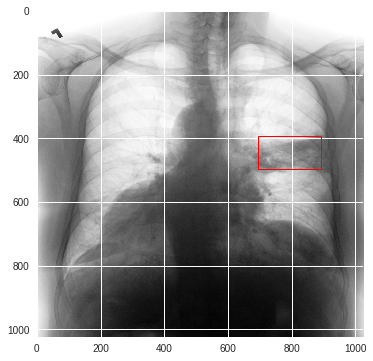

0.5761835420118968


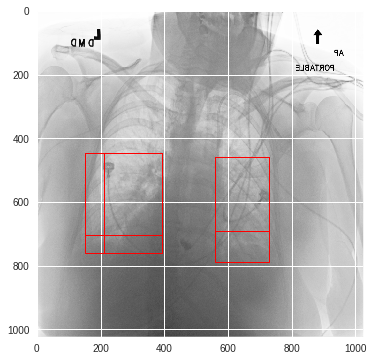

0.5779313688815875


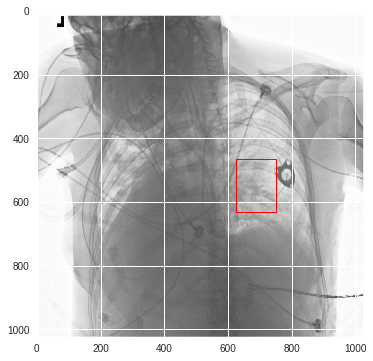

0.45471371839033653


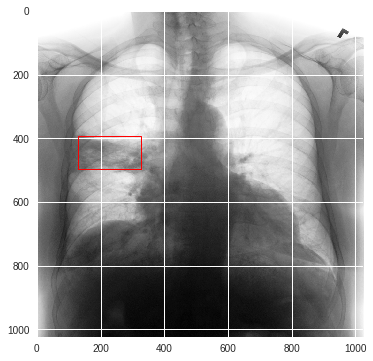

0.5804823632333792


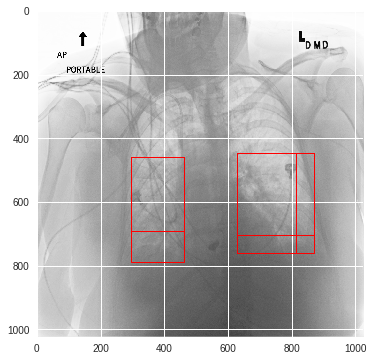

0.5837346469654747


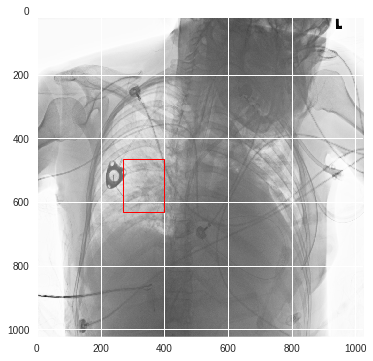

0.458395129344502


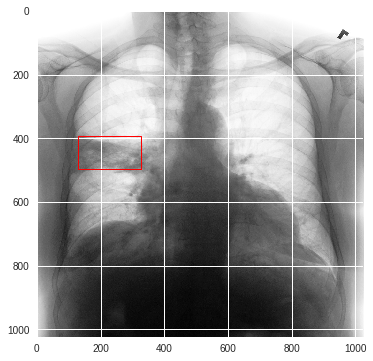

0.5767972200190414


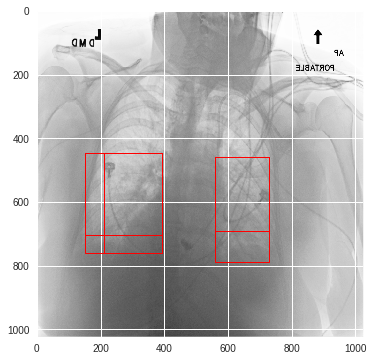

0.5837346469654747


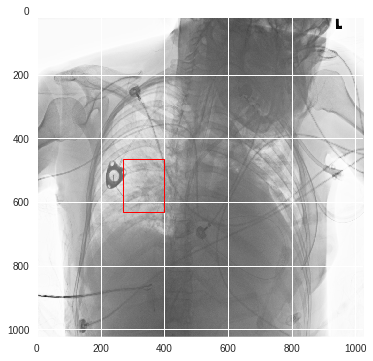

0.45623279520261606


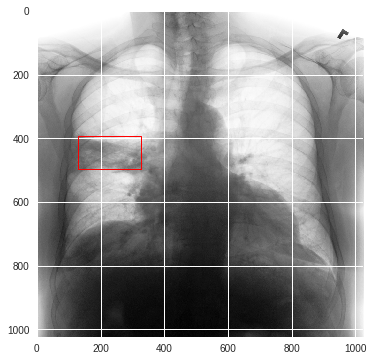

0.5769154915010422


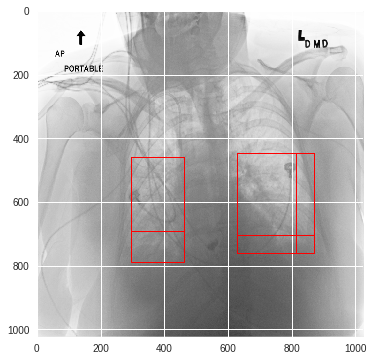

0.5837346469654747


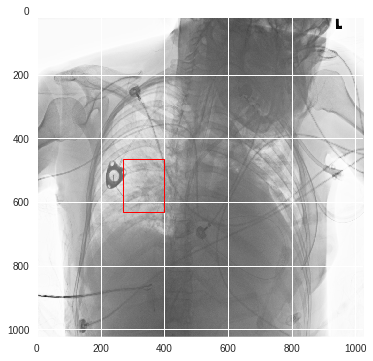

0.458395129344502


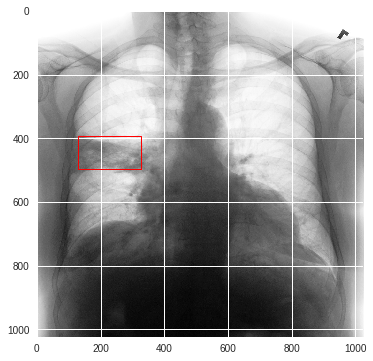

0.5804823632333792


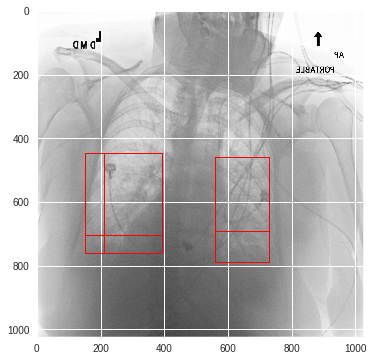

0.5837346469654747


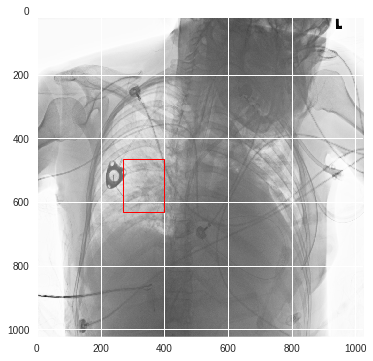

0.458395129344502


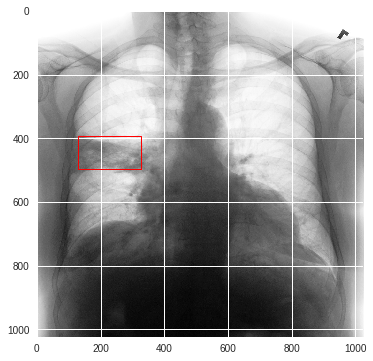

0.5786374231982623


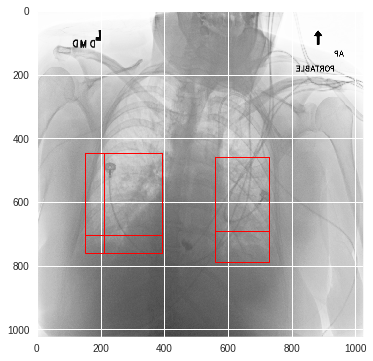

0.5804224690198573


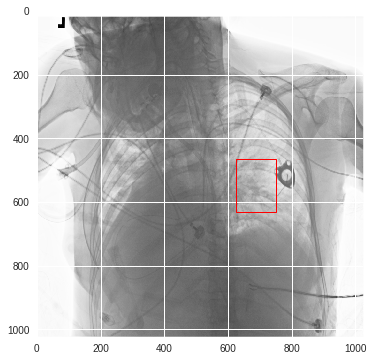

In [17]:
counter = 0
for imgs, labels in train_gen:
    for img, label in zip(imgs, labels):
        f, ax = plt.subplots(figsize=(6, 6))
        
        # display the image
        plt.imshow(np.squeeze(img))
        print(np.max(img))
        
        # show the labels
        rois = unnorm_label(label)
        
        for roi in rois:
            x, y, w, h, _ = roi
            
            rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        
        plt.show()
    
    counter += 1
    if counter > 5:
        break

# Network

In [0]:
# downsample with max pool
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

# downsample with conv with stride 2
def create_downsample_2(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', strides=(2,2), use_bias=False)(x)
    return x
  
def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x_2 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_2)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_2])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input - 448x448x3
    inputs = keras.Input(shape=(input_size, input_size, 1))
    
    # downsample to 224x224x24
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    # residual blocks
    for d in range(depth):
        
        if d > 0:
            x = create_downsample(channels, x)
        else:
            x = create_downsample_2(channels, x)
          
        channels = channels * 2
        
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.SpatialDropout2D(0.10)(x)
    
    # dilated conv for context - 14x14x512
#     x = keras.layers.Conv2D(512, (3,3), padding='same', activation=None, name="dilated_conv_1")(x)
#     x = keras.layers.BatchNormalization(momentum=0.9)(x)
#     x = keras.layers.LeakyReLU(0.1)(x)
#     x = keras.layers.SpatialDropout2D(0.15)(x)
   
    x = keras.layers.Conv2D(512, (3,3), padding='same', activation=None, name="last_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.SpatialDropout2D(0.20)(x)

    # downsample to 7x7 with stride 2
    x = keras.layers.Conv2D(768, (3,3), padding='same', strides=(3,3), activation=None, name="downsample_1", kernel_regularizer=keras.regularizers.l2(l=0.002))(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.SpatialDropout2D(0.15)(x)
    
    # confidence output branch
    c = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_1_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.SpatialDropout2D(0.15)(c)
    
    c = keras.layers.Conv2D(512, (1,1), padding='same', activation=None, name="fc_2_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(c)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.10)(c)
    
    confidence = keras.layers.Conv2D(1, (1,1), padding='same', activation="sigmoid", name="confidence_output")(c)
    
    # bounding box branch
    b = keras.layers.Conv2D(1568, (1,1), padding='same', activation=None, name="fc_1_b", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.SpatialDropout2D(0.15)(b)
    
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_2_b", kernel_regularizer=keras.regularizers.l2(l=0.01))(b)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.10)(b)
    
    boxes = keras.layers.Conv2D(4, (1,1), padding='same', activation="sigmoid")(b)
    output = keras.layers.concatenate([confidence, boxes], name="bboxes_output")
    
    # return both outputs
    model = keras.Model(inputs=inputs, outputs=output)
    
    return model

# Train network


In [0]:
## callbacks
class Calc_IOU_CB(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        # only do this every other epoch as it is slow on a CPU
        if epoch % 3 == 0:
            valid_gen2 = generator(train_dicom_dir, valid_filenames, pneumonia_locations, batch_size=32, image_size=IMAGE_SIZE, shuffle=True, predict=False)
            ious = []
            tps = 0
            fps = 0
            fns = 0

            counter = 0
            for imgs, labels in valid_gen2:
                preds = model.predict(imgs)

                for pred, label in zip(preds, labels):
                    yhat = unnorm_label(pred)
                    y_true = unnorm_label(label)

                    if len(yhat) or len(y_true):
                        iou = calc_iou_better(y_true, yhat)
                        ious.append(iou)

                # calculate the precision and recall
                tp, fp, fn = calc_tps(labels, preds)

                tps += tp
                fps += fp
                fns += fn

                counter += 32

                # only evaluate half of val set each epoch to speed up training
                if counter > len(valid_filenames) / 6:
                    break

            prec = tps / (tps + fps)
            recall = tps / (tps + fns)
            f1_score = 2 * (prec * recall) / (prec + recall)
            print("Epoch", epoch+1, ": Mean IOU:", np.mean(ious), "Precision:", prec, "Recall:", recall, "F1:", f1_score)
        
        return

class UploadCheckpointCB(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):      
        if epoch % 2 == 0:
            !gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/

        return
    
# count the true pos, false pos and false negatives so we can calculate precision and recall
def calc_tps(y_true, y_pred):
    true_confs = np.round(y_true[...,0])
    pred_confs = np.round(y_pred[...,0])
    
    tps = np.sum((pred_confs == 1) & (true_confs == 1))
    fps = np.sum((pred_confs == 1) & (true_confs != 1))
    fns = np.sum((pred_confs != 1) & (true_confs == 1))
    
    return tps, fps, fns      

# exponential learning rate decay
def exp_decay(x):
    lr0 = 0.01
    epochs_drop = 15
    drop = 0.75
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate


checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
learning_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)
catch_nan = tf.keras.callbacks.TerminateOnNaN()  
upload_checkpoint = UploadCheckpointCB()  
calc_iou = Calc_IOU_CB()

In [0]:
## LOSS FUNCTIONS AND METRICS
GRID_SIZE = 7
CELL_SIZE = 1024 / GRID_SIZE

# calculate f1 score with smoothing to avoid NaNs
def f1_score(y_true, y_pred):
    # apply sigmoid and round our labels
    y_pred = tf.round(y_pred[...,0])
    y_true = tf.round(y_true[...,0])

    # true positives are both pred and truth == 1
    tps = tf.reduce_sum(y_pred * y_true) + 1
    # false positives are truth == 0 and pred == 1
    not_y_true = tf.cast(tf.equal(y_true, 0), dtype=tf.float32)
    fps = tf.reduce_sum(y_pred * not_y_true)
    # false negatives is truth == 1 and pred == 0a
    not_y_pred = tf.cast(tf.equal(y_pred, 0), dtype=tf.float32)
    fns = tf.reduce_sum(y_true * not_y_pred)

    precision = tps / (tps + fps)
    recall = tps / (tps + fns)

    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

def binary_accuracy(y_true, y_pred):
    # apply sigmoid to our predictions and round to 0 or 1
    y_pred = tf.round(y_pred)
    y_true = tf.round(y_true)
    
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true[...,0], y_pred[...,0]), dtype=tf.float32))
    return acc

def overlap_iou(y_true, y_pred):
    """
    Args:
        bboxes1: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    
    # flatten the data because it's easier that way
    bboxes1 = tf.reshape(y_true, (-1, 5))
    bboxes2 = tf.reshape(y_pred, (-1, 5))
    
    # split the components out
    true_boxes, x11, y11, w1, h1 = tf.split(bboxes1, 5, axis=1)
    pred_conf, x21, y21, w2, h2 = tf.split(bboxes2, 5, axis=1)
    
    # make sure the truth is an int
    true_boxes = tf.round(true_boxes)
    
    # convert the sigmoid output to center coordinates
    # add some to avoid negative numbers
    x11 = (x11 * CELL_SIZE) + 512
    x21 = (x21 * CELL_SIZE) + 512
    y11 = (y11 * CELL_SIZE) + 512
    y21 = (y21 * CELL_SIZE) + 512
    
    # get the actual height and width numbers
    w1 = w1 * 1024
    w2 = w2 * 1024
    h1 = h1 * 1024
    h2 = h2 * 1024
    
    # only count the cell is there is actually an ROI here or if one is predicted
    mask = (pred_conf >= 0.5) | (tf.round(true_boxes) == 1)
    
    # get the far corners of the boxes
    x12 = x11 + (w1 / 2)
    y12 = y11 + (h1 / 2)
    x22 = x21 + (w2 / 2)
    y22 = y21 + (h2 / 2)
    
    x11 = x11 - (w1 / 2)
    y11 = y11 - (h1 / 2)
    x21 = x21 - (w2 / 2)
    y21 = y21 - (h2 / 2)

    # find the corners of the intersection area
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    # get the intersection area, if the truth has no boxes it is 0
    inter_area = true_boxes * (xI2 - xI1) * (yI2 - yI1)

    # get the area of each box
    bboxes1_area = (w1) * (h1)
    bboxes2_area = (w2) * (h2)
    
    # union is area of both boxes - intersection
    union = (bboxes1_area + bboxes2_area) - inter_area
    
    iou = tf.maximum(inter_area/(union + 1e-6), 0)
    
    # apply the mask
    iou = iou * tf.cast(mask, dtype=tf.float32)
    
    # reduce the mean so we have mean iou for our inputs
    return tf.reduce_mean(iou)
                    
def loss_fn(y_true, y_pred):  
    # get the xe loss
    xe_loss = binary_cross_entropy(y_true, y_pred)
    
    # get the box loss
    box_loss = adj_mse(y_true, y_pred)
    
    # add the losses and return them
    return (1.0 * xe_loss) + (box_loss * 10.0)

def adj_mse(y_true, y_pred):    
    # square the error
    square_error = tf.square(y_true[...,1:] - y_pred[...,1:])
    sse = tf.reduce_sum(square_error, axis=[3])
    
    # apply the mask so we only count the loss from cells with actual ROIs
    mask = y_true[...,0]
    
    sse = tf.multiply(sse, mask)
    
    loss = tf.reduce_sum(sse)            
            
    return loss  
  
# use weight of 0.5 for negative cells, 19 for positive ones
def binary_cross_entropy(y_true, y_pred):
    conf_true = tf.round(y_true[...,0])
    conf_pred = y_pred[...,0]
    
    weight = 5.0
    weights = tf.multiply(conf_true, weight) + 0.5
    
    xe = tf.multiply(tf.square(conf_true - conf_pred), weights)
    
    return tf.reduce_sum(xe)

def objectness_loss_fn(y_true, y_pred):
    
    # pred box conf
    pred_box_conf = y_pred[...,0]
    
    # separate the x, y from the w, h
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16)
    
    true_box_conf = iou_scores * y_true[..., 0]
    
    conf_mask  = tf.zeros_like(iou_scores)
    conf_mask = conf_mask + tf.cast((iou_scores < 0.6), dtype=tf.float32) * (1 - y_true[...,0])
    conf_mask = conf_mask + y_true[..., 0] * 5.0
    
    nb_conf_box  = tf.reduce_sum(tf.cast((conf_mask > 0.0), dtype=tf.float32)) 
    
    loss_conf  =  tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box + 1e-6) / 2.
    
    return tf.reduce_sum(loss_conf)

def iou_loss_fn(y_true, y_pred):
    
    # separate the x, y from the w, h and unnormalize them
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # get the area of the boxes
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    # calculate the IOU
    union_areas = pred_areas + true_areas - intersect_areas
    # multiple the IOU by the confidence so we have a more useful loss function
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16) * y_pred[...,0]
    
    # only use the IOU from boxes which actually have ROIs
    mask = y_true[...,0]
    
    # subtract IOU from 1 and apply the mask
    use_iou = (1 - iou_scores)
    use_iou = tf.multiply(use_iou, mask)
    
    return tf.reduce_sum(use_iou)

In [21]:
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=1, depth=4)

optimizer = keras.optimizers.Adam(lr=0.008, beta_1=0.9, beta_2=0.999, decay=0.0, clipnorm=1.0, clipvalue=0.5)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[binary_accuracy, adj_mse, binary_cross_entropy, overlap_iou, f1_score])

# model.load_weights(CHECKPOINT_PATH)

use_tpu = False
# if we are using the tpu copy the keras model to a new var and assign the tpu model to model
if use_tpu:
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    
    # create network and compiler
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model, strategy = tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
    
    BATCH_SIZE = BATCH_SIZE * 8
    
# create train and validation generators
folder = './stage_1_train_images'

# generators add augmentation with 1 having none and 4 having full augmentation. 
# generator 5 trains on all files, not separating out validation set to be used for final epochs
train_gen_1 = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=0, predict=False)
train_gen_2 = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=1, predict=False)
train_gen_3 = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=2, predict=False)
train_gen_4 = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=3, predict=False)
train_gen_5 = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=4, predict=False)
train_gen_6 = generator(folder, filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=4, predict=False)
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)

valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 336, 336, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 336, 336, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 336, 336, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 336, 336, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_norm

In [0]:
history = model.fit_generator(train_gen_1, validation_data=valid_gen, callbacks=[learning_rate, catch_nan, checkpoint, upload_checkpoint], epochs=20, shuffle=True, verbose=1, initial_epoch=0)

Epoch 1/20
 187/1174 [===>..........................] - ETA: 29:20 - loss: 201.6340 - binary_accuracy: 0.9338 - adj_mse: 7.1374 - binary_cross_entropy: 83.7492 - overlap_iou: 0.0029 - f1_score: 0.1596

In [0]:
history = model.fit_generator(train_gen_2, validation_data=valid_gen, callbacks=[learning_rate, catch_nan, checkpoint, upload_checkpoint], epochs=40, shuffle=True, verbose=1, initial_epoch=20)

In [0]:
history = tpu_model.fit_generator(train_gen_3, validation_data=valid_gen, callbacks=[learning_rate, catch_nan, checkpoint, upload_checkpoint], epochs=60, shuffle=True, verbose=1, initial_epoch=38)

In [0]:
history = tpu_model.fit_generator(train_gen_3, validation_data=valid_gen, callbacks=[learning_rate, catch_nan, checkpoint, upload_checkpoint], epochs=90, shuffle=True, verbose=1, initial_epoch=77)

In [0]:
history = tpu_model.fit_generator(train_gen_4, validation_data=valid_gen, callbacks=[learning_rate, catch_nan, checkpoint, upload_checkpoint], epochs=110, shuffle=True, verbose=1, initial_epoch=90)

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou loss")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou loss")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou loss")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou loss")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["iou_loss_fn"], label="Train iou loss")
plt.plot(history.epoch, history.history["val_iou_loss_fn"], label="Valid iou loss")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

## Sample Predictions

In [0]:
model.load_weights(CHECKPOINT_PATH)

In [0]:
THRESHOLD = 0.6
OVERLAP = 0.3
# look at some sample predictions
samples = np.random.choice(valid_filenames, size=20, replace=False)
# samples = problem_names

coords = np.arange(0, 1024, CELL_SIZE)
overall_ious = []
map_ious = []

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    
    # initialize our lists
    ious = []
    truths = []
    boxes = []
    
    # draw the truth boxes
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename].copy()
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0.5:
                    x, y, w, h = pixel_data[1:]
                    
                    # unnormalize the data
                    w = w * 1024
                    h = h * 1024
                    
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    # get the corners
                    x = x - (w // 2)
                    y = y - (h // 2)
                    
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    locs[i,j,:] = [1, x, y, w, h]
                    print("Truth:", i, j, x, y, w, h)
                    truths.append([x, y, w, h])
                    
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
                    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    conf = np.squeeze(yhat)[:,:,0]
    bboxes = np.squeeze(yhat)[:,:,1:]    
    pred_boxes = np.zeros_like(bboxes)
  
    # print the confidences for our true boxes, if any
    mask = (locs[...,0] > 0.5)
    
    # loop through our predictions
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            conf_ = conf[i,j]
            # if we have a prediction
            if conf_ > THRESHOLD:
                x,y,w,h = bboxes[i,j,:]
                
                # unnormalize the data
                w = w * 1024
                h = h * 1024

                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)
                
                # convert to upper left corner from center
                x = np.maximum(x - (w // 2), 0)
                y = np.maximum(y - (h // 2), 0)
                
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                
                pred_boxes[i,j,:] = [x, y, w, h]
                
                print("Pred:", i, j, "conf:", conf_, x, y, w, h)
                
                # if the boxes have width and height add them to our list
                if w > 30 and h > 30:
                    boxes.append([x,y,w,h, conf_])
            elif mask[i,j]:
              print("False Negative:", i, j, "conf:", conf_)
              
    ## if we have ground truths OR predictions calculate the IOUs:
    if len(boxes) or len(truths):
        # do non-max suppression of our boxes
        nms_boxes = non_max_suppression_fast(np.array(boxes), OVERLAP)

        # only count the IOU if there are either ground truths or predictions
        if len(nms_boxes) or len(truths):
            iou = calc_iou_better(np.array(truths), np.array(nms_boxes))
            print("IOU post-nms:", iou)
            overall_ious.append(iou)

        # plot our boxes
        for box in nms_boxes:
            x,y,w,h,c = box
            rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        if len(nms_boxes):
            scores = nms_boxes[...,4]
        else:
            scores = np.array([])

        map_iou_score = map_iou(np.array(truths), np.array(nms_boxes), scores)

        if map_iou_score is not None:
            map_ious.append(map_iou_score)

        for item in coords:
            plt.axvline(item, linewidth=0.5)
            plt.axhline(item, linewidth=0.5)

        print("IOU:", iou)
        print("Map IOU:", map_iou_score)
    
    plt.title(filename)
    plt.show()
    
print("Overall Mean IOU:", np.mean(overall_ious))    
print("Overall Map IOU:", np.mean(map_ious))    

## Threshold Curves

In [0]:
def scores_at_threshold(y_true, y_pred, thresholds=[0.5, 0.55, 0.6,0.65, 0.7,0.75, 0.8, 0.85, 0.9]):
    prec_scores = []
    rec_scores = []
    iou_scores = []
    accuracy_scores = []
    
    # calculate the scores
    for threshold in thresholds:
        # extract the prediction from the input
        pred_true = (y_pred[...,0] > threshold) * 1.0
        gt_true = np.round(y_true[...,0])

        # calculate the prec, rec, accuracy
        accuracy = np.mean((pred_true == gt_true) * 1.0)
        
        tp = np.sum(pred_true * gt_true)
        fp = np.sum(pred_true * (gt_true == 0))
        fn = np.sum(gt_true * (pred_true == 0))
        
        # if there are true ROIs and predictions
        if (np.sum(gt_true) > 0) and (np.sum(pred_true) > 0):
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
        # else if there are no truths but there are preds it is 0
        elif (np.sum(gt_true) == 0) and (np.sum(pred_true) > 0):
            precision = 0
            recall = 0
        # else if both are 0 we predicted all correctly
        else:
            precision = 1
            recall = 1
        
        accuracy_scores.append(accuracy)
        prec_scores.append(precision)
        rec_scores.append(recall)
        
        temp_ious = []
        # calculate the IOU
        for gt_, yhat_ in zip(y_true, y_pred):
            # if there are true ROIs calculate the ROI
            gt_rois = unnorm_label(np.squeeze(gt_), threshold)
            pred_rois = unnorm_label(np.squeeze(yhat_), threshold)

            iou = calc_iou_better(gt_rois, pred_rois)
            temp_ious.append(iou)

        iou_scores.append(np.mean(temp_ious))
        
    return prec_scores, rec_scores, iou_scores, accuracy_scores, thresholds

def plot_thresholds(thresholds=[0.5, 0.55, 0.6,0.65, 0.7,0.75, 0.8, 0.85, 0.9], iterations=30):
    precs = np.zeros_like(thresholds)
    recs = np.zeros_like(thresholds)
    ious = np.zeros_like(thresholds)
    accs = np.zeros_like(thresholds)

    counter = 0
    for imgs, labels in valid_gen:
        preds = model.predict(imgs)
        prec, rec, iou, acc, th = scores_at_threshold(labels, preds, thresholds)
        precs += np.array(prec)
        recs += np.array(rec)
        ious += np.array(iou)
        accs += np.array(acc)

        counter += 1
        if counter > iterations:
            precs /= counter
            recs /= counter
            ious /= counter
            accs /= counter
            break
            
    plt.plot(thresholds, ious, color="red", label="IOU")
    plt.legend()
    plt.show()
    
    plt.plot(thresholds, recs, color="red", label="Recall")
    plt.plot(thresholds, precs, color="green", label="Precision")
    plt.plot(thresholds, accs, color="blue", label="Accuracy")
    plt.legend()
    plt.show()

In [0]:
plot_thresholds([0.5, 0.55, 0.6,0.65, 0.7,0.75, 0.8, 0.85, 0.9], iterations=30)

# Predict test images

In [0]:
THRESHOLD = 0.7

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=24, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    yhats = model.predict(imgs)
    
    # loop through batch
    for yhat, filename in zip(yhats, filenames):
        predictionString = ""
        boxes = []
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                conf = yhat[i, j, 0]
                if conf > THRESHOLD:
                    x, y, w, h = yhat[i,j, 1:]
                    
                    # possible thresholds to keep our boxes within reasonable sizes?
                    if True: #w < 600 and h < 1000:
                        w = w * 1024
                        h = h * 1024

                        x = unnorm(x, j, CELL_SIZE)
                        y = unnorm(y, i, CELL_SIZE)

                        # convert to upper left corner from center
                        x = x - (w // 2)
                        y = y - (h // 2)
                        
                        if w > 20 and h > 20:
                            # make sure our boxes don't run off the edges of the images
                            w = np.minimum(w, 1024 - x)
                            h = np.minimum(h, 1024 - y)
                            boxes.append([x,y,w,h])

        # do our non-max suppression here
        boxes = non_max_suppression_fast(np.array(boxes), 0.3)
        
        # loop through our suppressed boxes and creat the prediction string
        for box in boxes:
            x,y,w,h = box
            
            x = int(x)
            y = int(y)
            w = int(w)
            h = int(h)
        
            # create the prediction string
            predictionString += str(0.9) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '
            
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

In [0]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f {submission_file} -m "YOLOv25.1 448x448 60 epochs"

In [0]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/